In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
%matplotlib inline

In [2]:
def show(img, convert=False):
    if convert:
        plt_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(plt_img)
    else:
        plt.imshow(img, cmap='gray')
    plt.show()

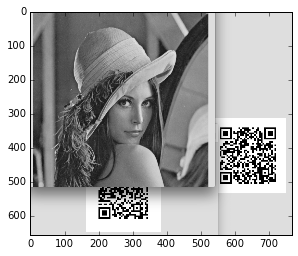

In [3]:
qr_origin = cv2.imread('./test_pictures/qr_code_mixed.png')
qr_origin = cv2.cvtColor(qr_origin, cv2.COLOR_BGR2RGB)
qr_gray = cv2.cvtColor(qr_origin, cv2.COLOR_BGR2GRAY)
show(qr_gray)

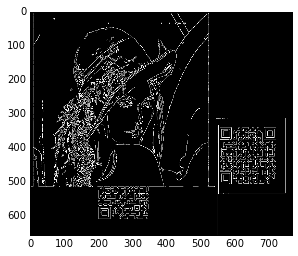

In [4]:
edges = cv2.Canny(qr_origin, 100, 200)
show(edges)

In [5]:
contours, hierarchy = cv2.findContours(edges, cv2.RETR_TREE,
                                      cv2.CHAIN_APPROX_SIMPLE)

In [6]:
len(hierarchy)

1

In [7]:
hierarchy = hierarchy[0]
len(hierarchy)

871

In [8]:
found = []
for i in range(len(contours)):
    k = i
    c = 0
    while hierarchy[k][2] != -1:
        k = hierarchy[k][2]
        c += 1
    if c >= 5:
        found.append(i)

In [9]:
found

[13, 118, 438, 450]

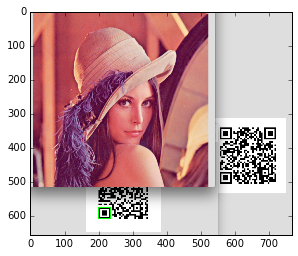

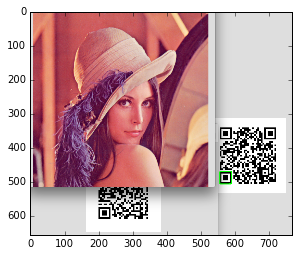

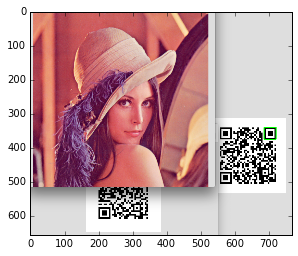

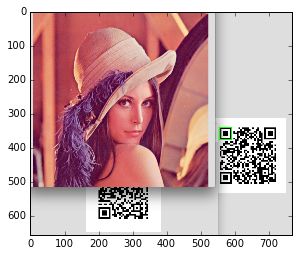

In [10]:
for i in found:
    qr_dc = qr_origin.copy()
    cv2.drawContours(qr_dc, contours, i, (0, 255, 0), 2)
    show(qr_dc)

In [11]:
contours_points = []
for i in found:
    c = contours[i]
    for sublist in c:
        for p in sublist:
            contours_points.append(p)

In [12]:
rect = cv2.minAreaRect(np.array(contours_points))
box = cv2.cv.BoxPoints(rect)
box = np.array(box)

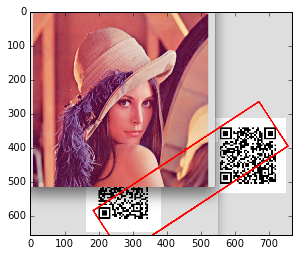

In [13]:
draw_img = qr_origin.copy()
cv2.polylines(draw_img, np.int32([box]), True, (255, 0, 0), 4)
show(draw_img)

### To fix above problem

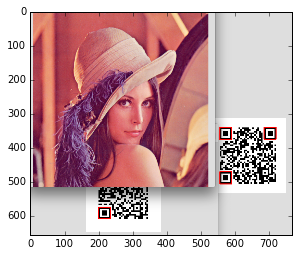

In [14]:
draw_img = qr_origin.copy()
for i in found:
    rect = cv2.minAreaRect(contours[i])
    box = np.int0(cv2.cv.BoxPoints(rect))
    cv2.drawContours(draw_img, [box], 0, (255, 0, 0), 2)
show(draw_img)

In [15]:
boxes = []
for i in found:
    rect = cv2.minAreaRect(contours[i])
    box = np.int0(cv2.cv.BoxPoints(rect))
    box = map(tuple, box)
    boxes.append(box)
boxes

[[(199, 608), (199, 574), (235, 574), (235, 608)],
 [(554, 506), (554, 470), (588, 470), (588, 506)],
 [(683, 375), (683, 340), (718, 340), (718, 375)],
 [(554, 376), (554, 340), (588, 340), (588, 376)]]

In [16]:
import math

In [17]:
def distance(p, q):
    return int(math.sqrt(pow((p[0] - q[0]), 2) + pow((p[1] - q[1]), 2)))

In [18]:
def two_nearest_line(b1, b2):
    distances = []
    for p in b1:
        for q in b2:
            distances.append([distance(p, q), (p, q)])
    distances = sorted(distances, key=lambda d: d[0])
    return distances[0], distances[1]

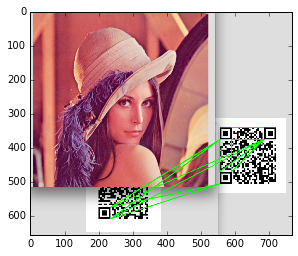

In [19]:
draw_img = qr_origin.copy()
for i in range(len(boxes)):
    for j in range(i+1, len(boxes)):
        d1, d2 = two_nearest_line(boxes[i], boxes[j])
        cv2.line(draw_img, d1[1][0], d1[1][1], (0, 255, 0), 2)
        cv2.line(draw_img, d2[1][0], d2[1][1], (0, 255, 0), 2)
show(draw_img)

In [20]:
th, qr_bi = cv2.threshold(qr_gray, 100, 255, cv2.THRESH_BINARY)

In [21]:
qr_bi.shape

(656, 768)

In [22]:
# line iterator test
import LineIterator

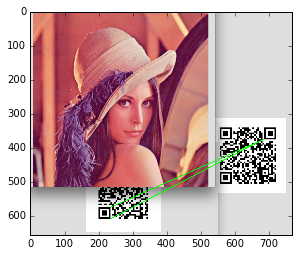

In [23]:
test_d1, test_d2 = two_nearest_line(boxes[0], boxes[2])
draw_img = qr_origin.copy()
for d in [test_d1, test_d2]:
    cv2.line(draw_img, d[1][0], d[1][1], (0, 255, 0), 2)
show(draw_img)

In [24]:
test_p, test_q = test_d2[1][0], test_d2[1][1]

In [25]:
line_pixels = LineIterator.createLineIterator(P1=test_p, P2=test_q, img=qr_bi)

In [26]:
line_pixels[:, 2]

array([ 255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,  255.,  255.,  255.,  255.,  255.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,  255.,  255.,
        255.,  255.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        255.,  255.,  255.,    0.,    0.,  255.,  255.,  255.,  255.,
        255.,    0.,    0.,    0.,    0.,    0.,  255.,  255.,  255.,
        255.,  255.,  255.,  255.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,  255.,  255.,  255.,    0.,
          0.,    0.,    0.,    0.,  255.,  255.,  255.,  255.,  255.,
        255.,  255.,  255.,  255.,  255.,    0.,  255.,  255.,  255.,
        255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,
        255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,  255.,
        255.,  255.,

In [27]:
def is_timing_pattern(line, threshold=5):
    while line[0] != 0:
        line = line[1:]
        if not len(line):
            return False
    while line[-1] != 0:
        line = line[:-1]
        if not len(line):
            return False
    c = []
    count = 1
    l = line[0]
    for p in line[1:]:
        if p == l:
            count += 1
        else:
            c.append(count)
            count = 1
        l = p
    c.append(count)
    if len(c) < 5:
        return False
    return np.var(c) < threshold

In [28]:
is_timing_pattern(line_pixels[:, 2])

False

In [29]:
def get_valid_boxes_index(boxes):
    timing_patterns = []
    boxes_index = set()
    for i in range(len(boxes)):
        for j in range(i+1, len(boxes)):
            d1, d2 = two_nearest_line(boxes[i], boxes[j])
            for d in [d1[1], d2[1]]:
                line_pixels = LineIterator.createLineIterator(d[0], d[1], qr_bi)
                if is_timing_pattern(line_pixels[:, 2]):
                    timing_patterns.append((d[0], d[1]))
                    boxes_index.add(i)
                    boxes_index.add(j)
    return boxes_index, timing_patterns

In [30]:
boxes_index, timing_patterns = get_valid_boxes_index(boxes)

In [31]:
boxes_index

{1, 2, 3}

In [32]:
timing_patterns

[((588, 470), (588, 376)), ((683, 375), (588, 376))]

In [33]:
len(timing_patterns)

2

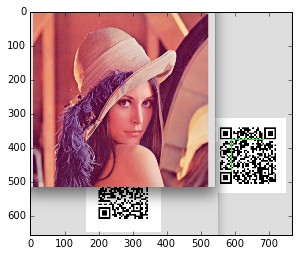

In [34]:
draw_img = qr_origin.copy()
for timing_pattern in timing_patterns:
    cv2.line(draw_img, timing_pattern[0], timing_pattern[1], (0, 255, 0), 2)
show(draw_img)

In [35]:
contours_points = []
while len(boxes_index) > 0:
    c = contours[found[boxes_index.pop()]]
    for sublist in c:
        for p in sublist:
            contours_points.append(p)

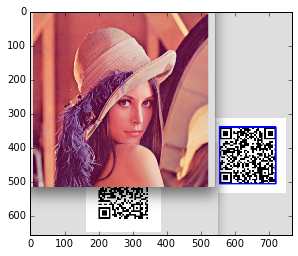

In [36]:
draw_img = qr_origin.copy()
rect = cv2.minAreaRect(np.array(contours_points))
box = np.array(cv2.cv.BoxPoints(rect))
cv2.polylines(draw_img, np.int32([box]), True, (0, 0, 255), 4)
show(draw_img)